In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# Systemparameter
# yp = a * y + b * ( u + z )
# k ... Rückführverstärkung
# l ... Beobachterverstärkung
# T ... Überführungsdauer für Vorsteuerung (T = 0 bedeutet Sprung)

a = -1
b = 1.0
k = 50
l = 25

Kp = l + k
Ki = l * ( b * k - a )

def yref(t):
    return 1;
    
def disturbance(t):
    if (t < 2.0):
        return 1.0;
    else:
        return 0.0
        

def dclosed_loop(x,t,yref,a,b,Ki,Kp,umax=2.0,windup=0):
    y=x[0]
    uref=a/b*yref(t)
    #Regler
    if windup==0: # ohne Anti-Windup und ohne Vorsteuerung
        u = -Ki*x[1]-Kp*(y-yref(t))
        d_xi = y-yref(t)
    elif windup==1: # Standard PI Konfiguration, Stoppt Integration
        u = -Ki*x[1]-Kp*(y-yref(t))
        d_xi = y-yref(t)
        if abs(u)>=umax:
            d_xi = 0
    elif  windup==2: # Beobachterformulierung lt. LV
        u = uref-Kp*(y-yref(t))-x[1]
        u = min(umax,max(-umax,u))
        d_xi = -Ki/Kp*(x[1]+(u-uref))
    elif windup==3: # Beobachterformulierung ohne entsprechende Umrechnung (y-yref = -(eta+u-uref)/Kp)
        u = uref-(k+l)*(y-yref(t))-x[1]
        u = min(umax,max(-umax,u))
        d_xi = -l*b*x[1]-l*(l*b+a)*(y-yref(t))-l*b*(u-uref)
        

    #Strecke
    u = min(umax,max(-umax,u))
    
    dy = a * x[0] + b * ( u + disturbance(t) )
    dx = [dy,d_xi]
    return dx
    
t = np.linspace(0,5,5000)
x0 = np.array([0,0])
umax = 2.0

x_nominal=odeint(dclosed_loop,x0,t,args=(yref,a,b,Ki,Kp,100.0,0))
x_bounded=odeint(dclosed_loop,x0,t,args=(yref,a,b,Ki,Kp,umax,0))
x_bounded_antiwindup1=odeint(dclosed_loop,x0,t,args=(yref,a,b,Ki,Kp,umax,1))
x_bounded_antiwindup2=odeint(dclosed_loop,x0,t,args=(yref,a,b,Ki,Kp,umax,2))
x_bounded_antiwindup3=odeint(dclosed_loop,x0,t,args=(yref,a,b,Ki,Kp,umax,3))

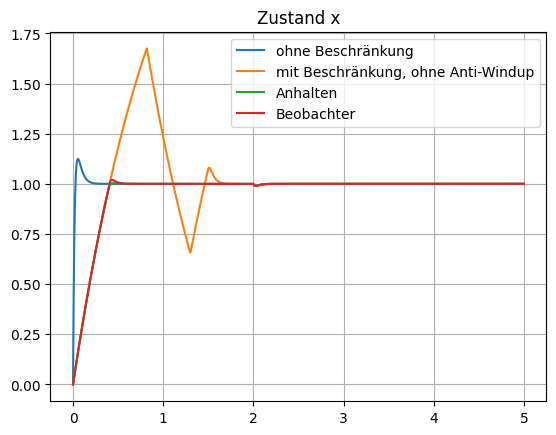

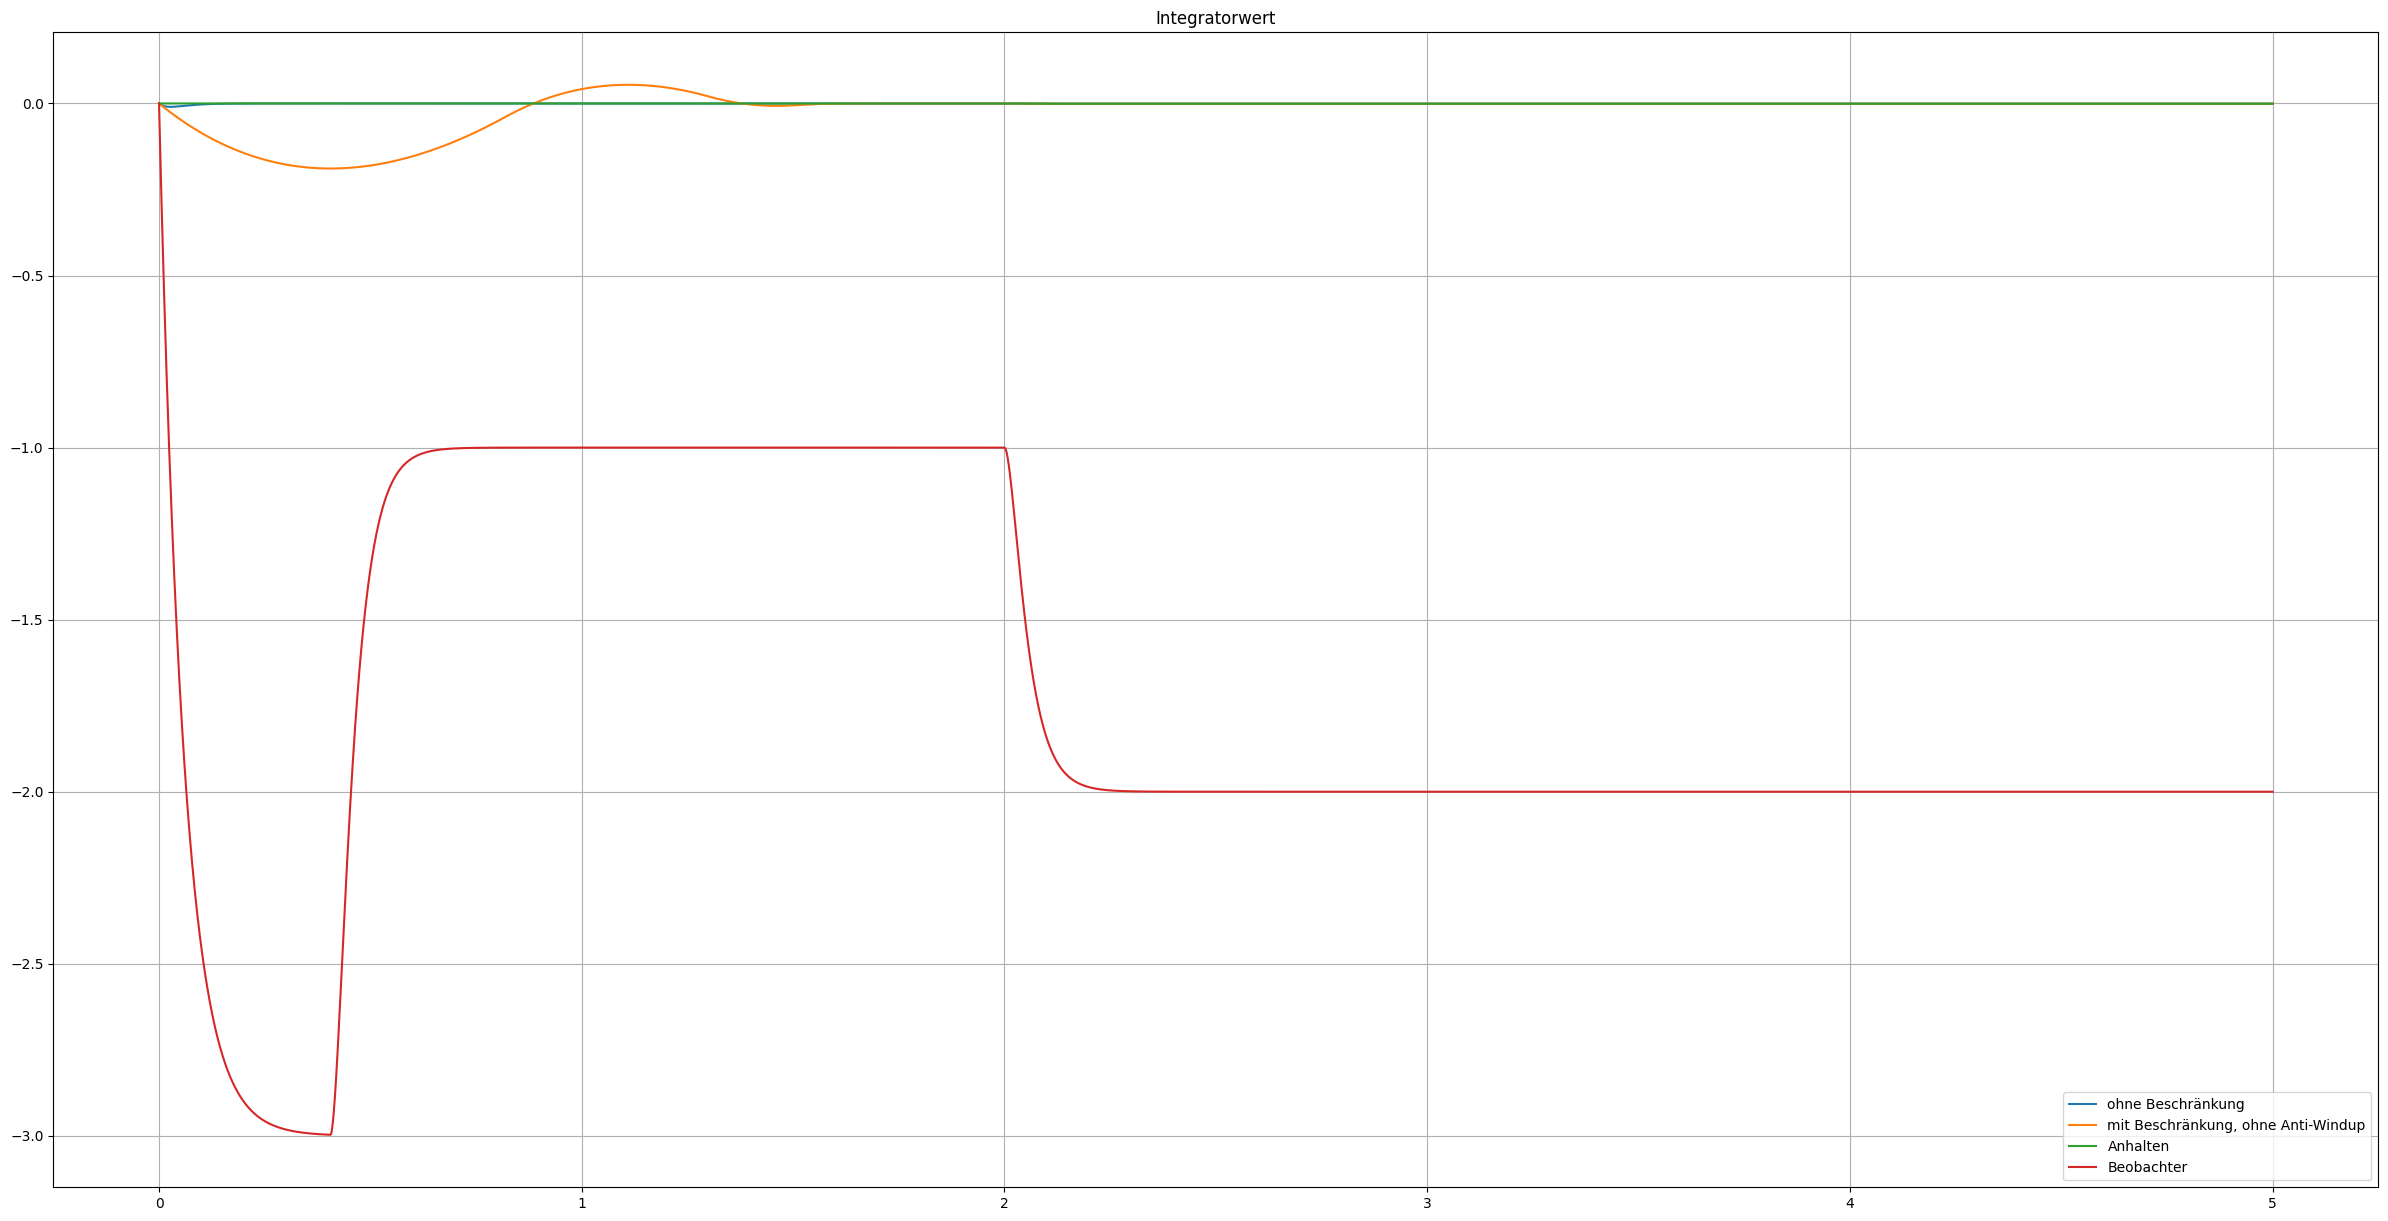

In [3]:
plt.figure(1)
plt.clf()
plt.plot(t,x_nominal[:,0])
plt.plot(t,x_bounded[:,0])
plt.plot(t,x_bounded_antiwindup1[:,0])
plt.plot(t,x_bounded_antiwindup2[:,0])
plt.grid()
plt.title("Zustand x")
plt.legend(["ohne Beschränkung","mit Beschränkung, ohne Anti-Windup","Anhalten","Beobachter"])
plt.rcParams['figure.figsize'] = [30, 15]
plt.figure(2)
plt.clf()
plt.plot(t,x_nominal[:,1])
plt.plot(t,x_bounded[:,1])
plt.plot(t,x_bounded_antiwindup1[:,1])
plt.plot(t,x_bounded_antiwindup2[:,1])
plt.grid()
plt.title("Integratorwert")
plt.legend(["ohne Beschränkung","mit Beschränkung, ohne Anti-Windup","Anhalten","Beobachter"])
plt.rcParams['figure.figsize'] = [30, 15]


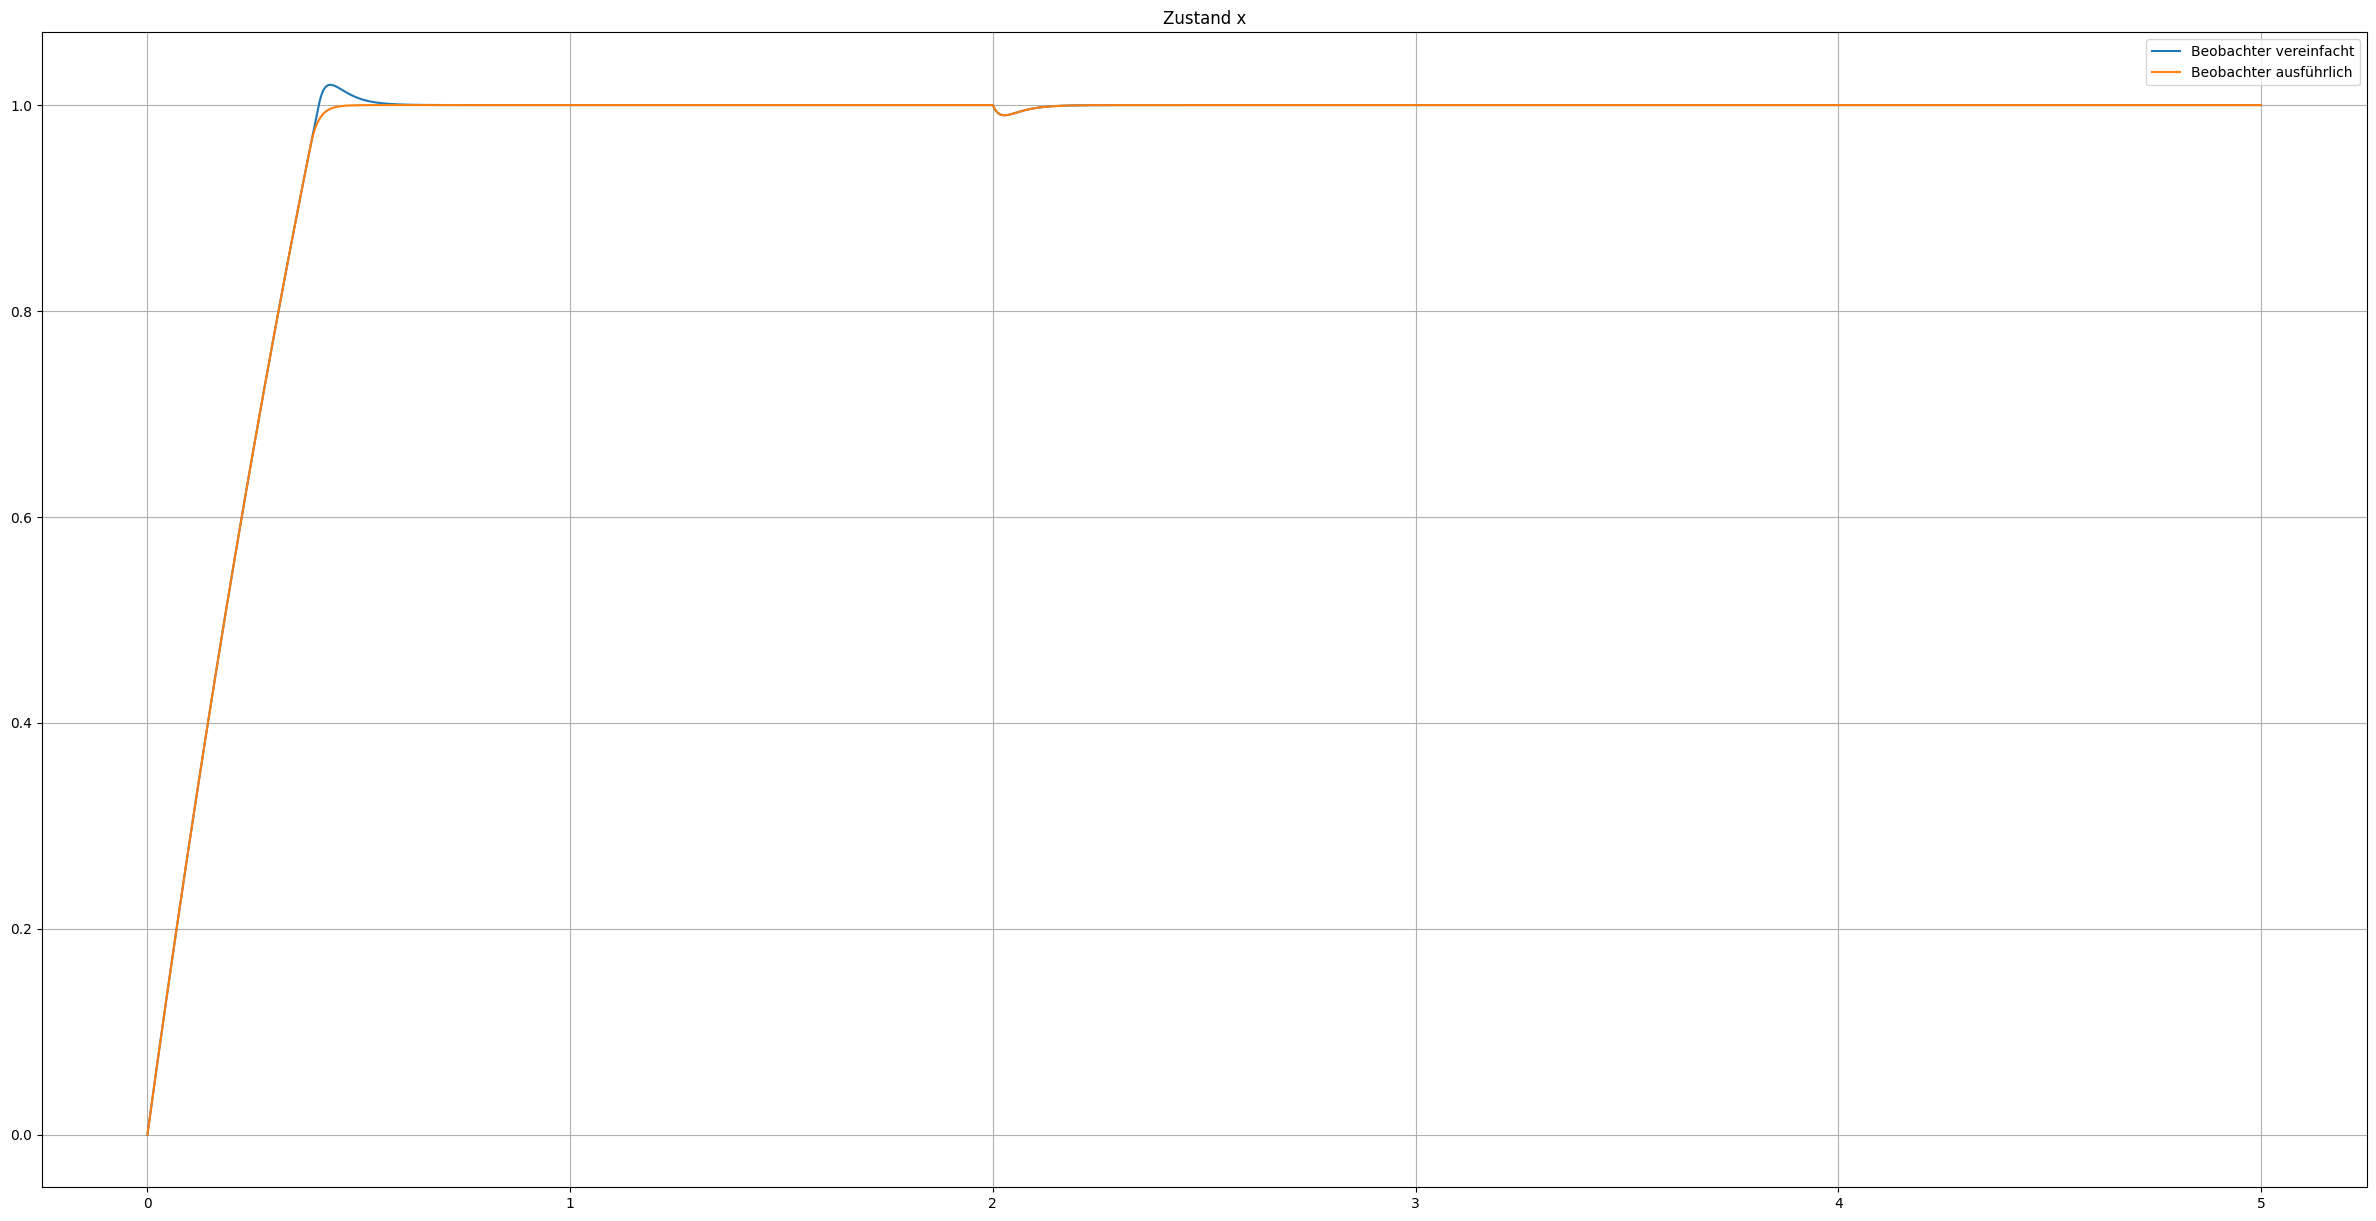

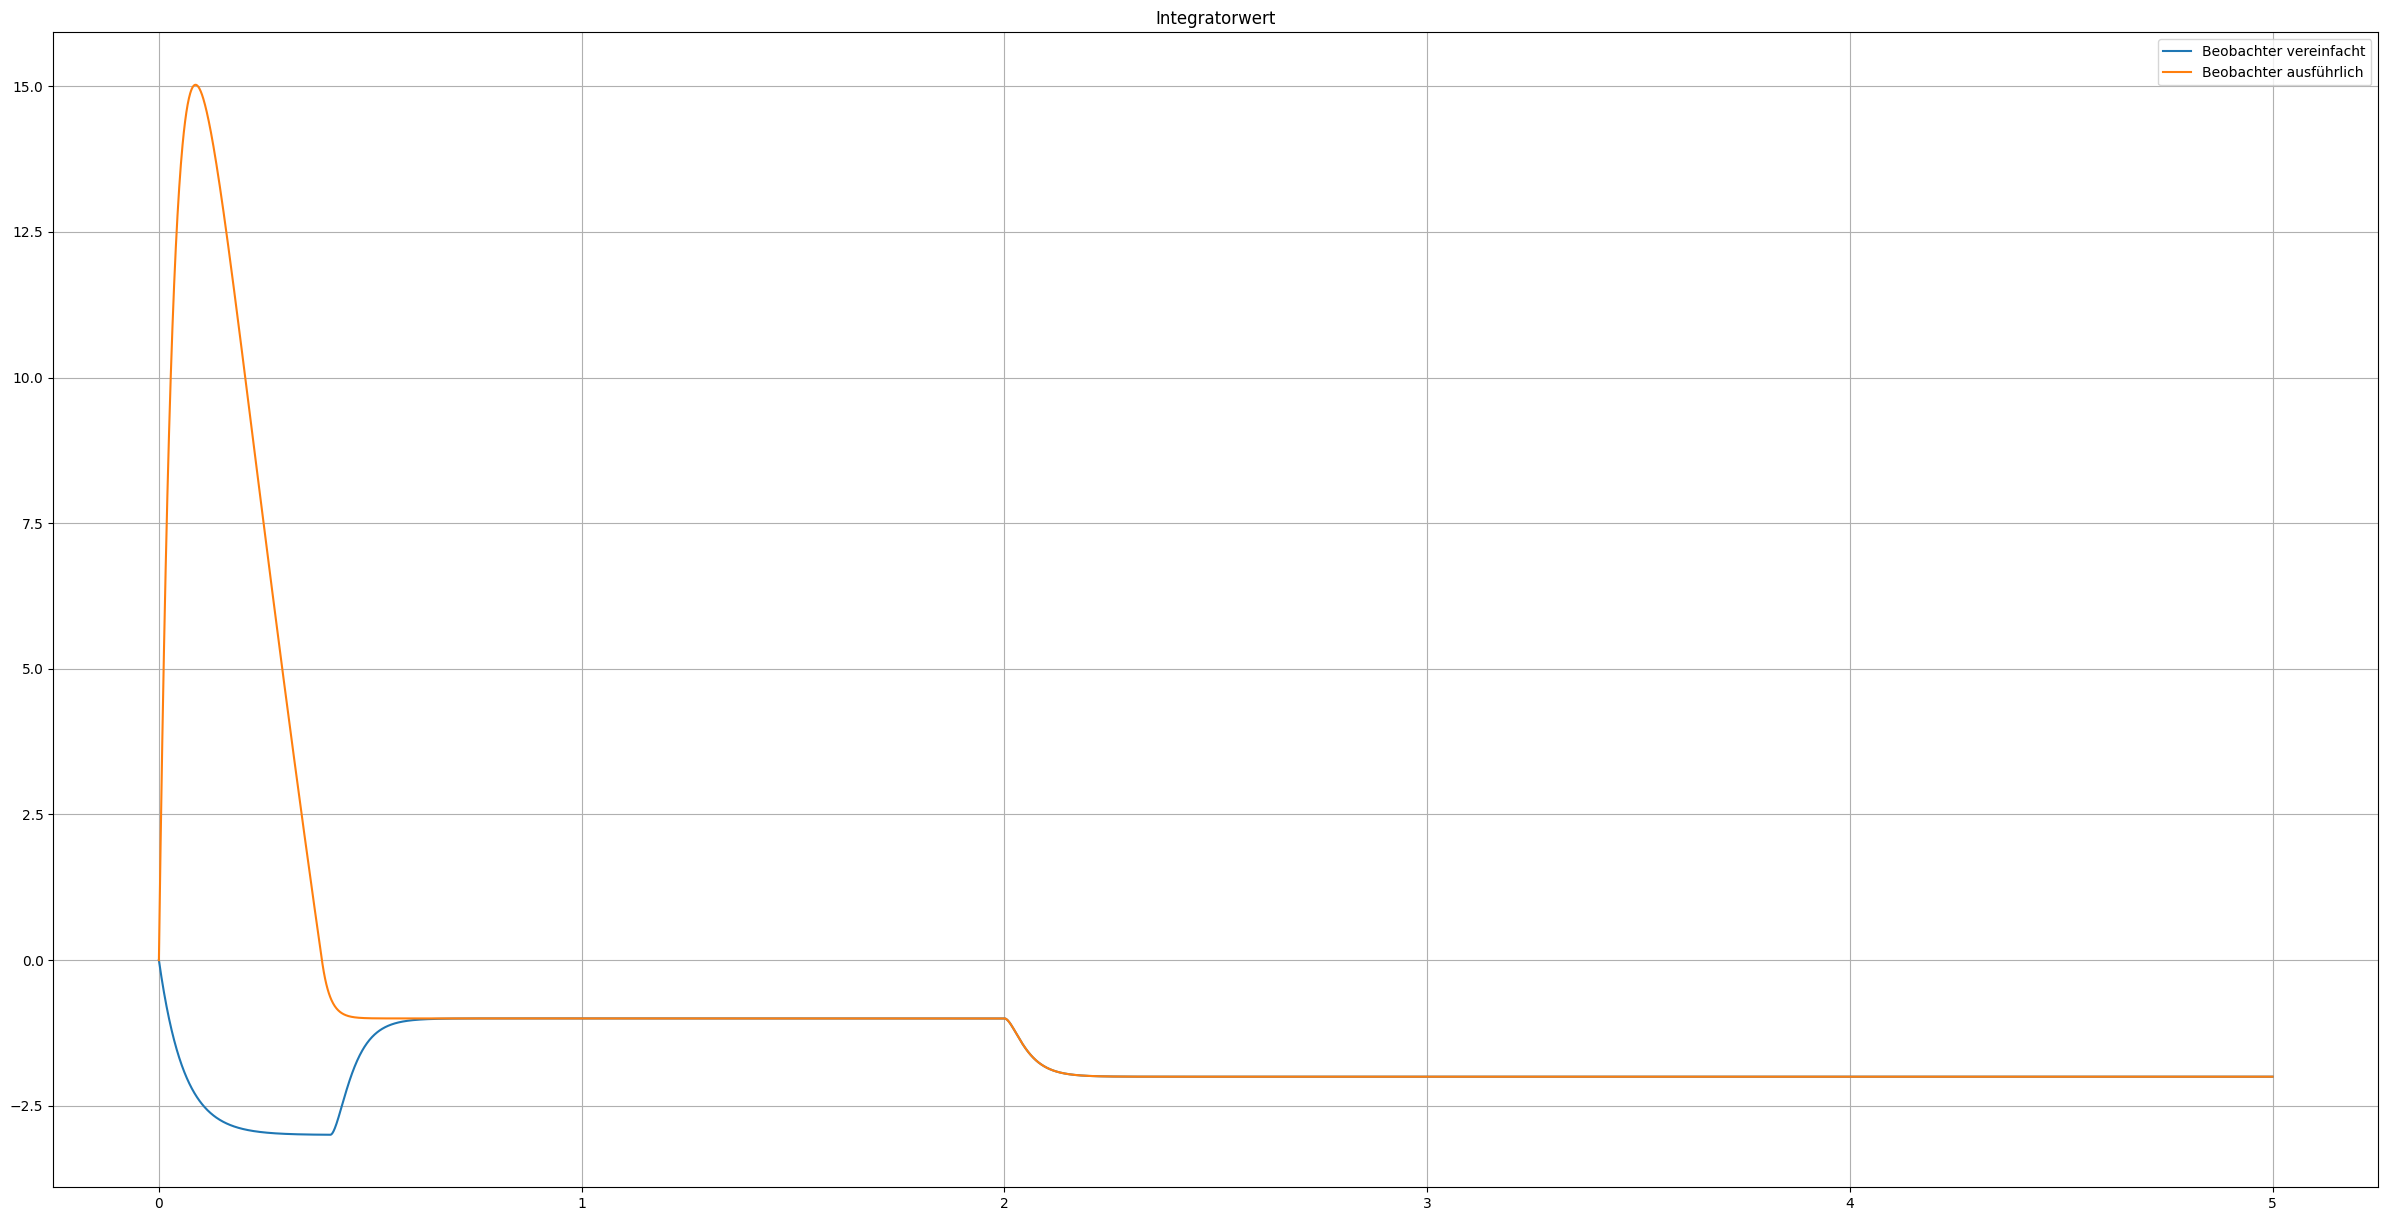

In [4]:
# Der Unterschied in den beiden Methoden liegt bei der Berücksichtigung der Beschränkung bereits bei vor der Integration.
# Bei der ausführlichen Methode wird y_tilde nicht ersetzt, wodurch der Spung im Referenzsignal auch bei der Überführung seine Wirkung zeigt wohingegend bei der vereinfachten Implementierung der Ausgangsfehler ersetzt wird und dadurch die Beschränkung berücksichtigt wird.

plt.figure(1)
plt.plot(t,x_bounded_antiwindup2[:,0])
plt.plot(t,x_bounded_antiwindup3[:,0])
plt.grid()
plt.title("Zustand x")
plt.legend(["Beobachter vereinfacht","Beobachter ausführlich"])
plt.rcParams['figure.figsize'] = [30, 15]

plt.show()

plt.figure(2)
plt.plot(t,x_bounded_antiwindup2[:,1])
plt.plot(t,x_bounded_antiwindup3[:,1])
plt.grid()
plt.title("Integratorwert")
plt.legend(["Beobachter vereinfacht","Beobachter ausführlich"])
plt.rcParams['figure.figsize'] = [30, 15]

plt.show()